In [1]:
from flickplay.get_connections import get_alchemy_con
import pandas as pd
from flickplay.utils import timer_func


con = get_alchemy_con()

['date', 'distinct_id', 'duration_ms', 'distance_m', 'deeplink_type', 'deeplink_url', 'destination_coin_type', 'destination_id', 'destination_name', 'destination_type', 'display_avatar']


In [2]:
q = '''
select 
    `$model` model, 
    $user_id user_id,
    date,
    month(date) month_,
    year(date) year_
from fpa.events
where anon_user=0
'''

@timer_func
def get_devices(query=q):
    return pd.read_sql(query, con)


Function 'get_devices' executed in 113.9687s


In [24]:
# d2 = get_devices()
d2

,model,user_id,date,month_,year_
0,x86_64,None,2022-02-02,2,2022
1,x86_64,None,2022-02-02,2,2022
2,x86_64,None,2022-02-02,2,2022
3,x86_64,None,2022-02-02,2,2022
4,x86_64,None,2022-02-02,2,2022
...,...,...,...,...,...
10906955,"iPhone12,1",62d5044122648df88a71ed06,2022-12-31,12,2022
10906956,"iPhone12,1",62d5044122648df88a71ed06,2022-12-31,12,2022
10906957,"iPhone12,1",62d5044122648df88a71ed06,2022-12-31,12,2022
10906958,"iPhone12,1",62d5044122648df88a71ed06,2022-12-31,12,2022


In [20]:
# devices

In [26]:
#d2 = get_devices()
devices = d2.copy()
devices['date'] = d2.date.apply(lambda x: '-'.join(str(x).split('-')[:-1]))
devices


,model,user_id,date,month_,year_
0,x86_64,None,2022-02,2,2022
1,x86_64,None,2022-02,2,2022
2,x86_64,None,2022-02,2,2022
3,x86_64,None,2022-02,2,2022
4,x86_64,None,2022-02,2,2022
...,...,...,...,...,...
10906955,"iPhone12,1",62d5044122648df88a71ed06,2022-12,12,2022
10906956,"iPhone12,1",62d5044122648df88a71ed06,2022-12,12,2022
10906957,"iPhone12,1",62d5044122648df88a71ed06,2022-12,12,2022
10906958,"iPhone12,1",62d5044122648df88a71ed06,2022-12,12,2022


In [27]:
def count_distinct(x):
    return len(set(x))

devices_gr1 = devices[['model','user_id']].groupby('model').count()
devices_gr1 

,user_id
model,
"MacBookPro18,1",176340
arm64,49
"iPad11,1",13
"iPad11,2",794
"iPad11,3",286
...,...
"iPhone9,2",26250
"iPhone9,3",110314
"iPhone9,4",7094


In [41]:
def count_distinct(x):
    return len(set(x))


# this is the count of users with a given device
@timer_func
def get_devices2():
    return devices[['model','user_id']].groupby('model')['user_id']\
                                       .apply(count_distinct)\
                                       .reset_index()\
                                       .sort_values(by='user_id', ascending=False)
devices_gr2 = get_devices2()
devices_gr2

Function 'get_devices2' executed in 17.3684s


,model,user_id
47,"iPhone12,1",853
54,"iPhone13,4",557
56,"iPhone14,3",461
46,"iPhone11,8",459
52,"iPhone13,2",457
...,...,...
35,"iPad8,5",1
34,"iPad8,3",1
33,"iPad8,12",1
32,"iPad8,11",1


Text(0.5, 1.0, 'Distribution of Devices on Flickplay')

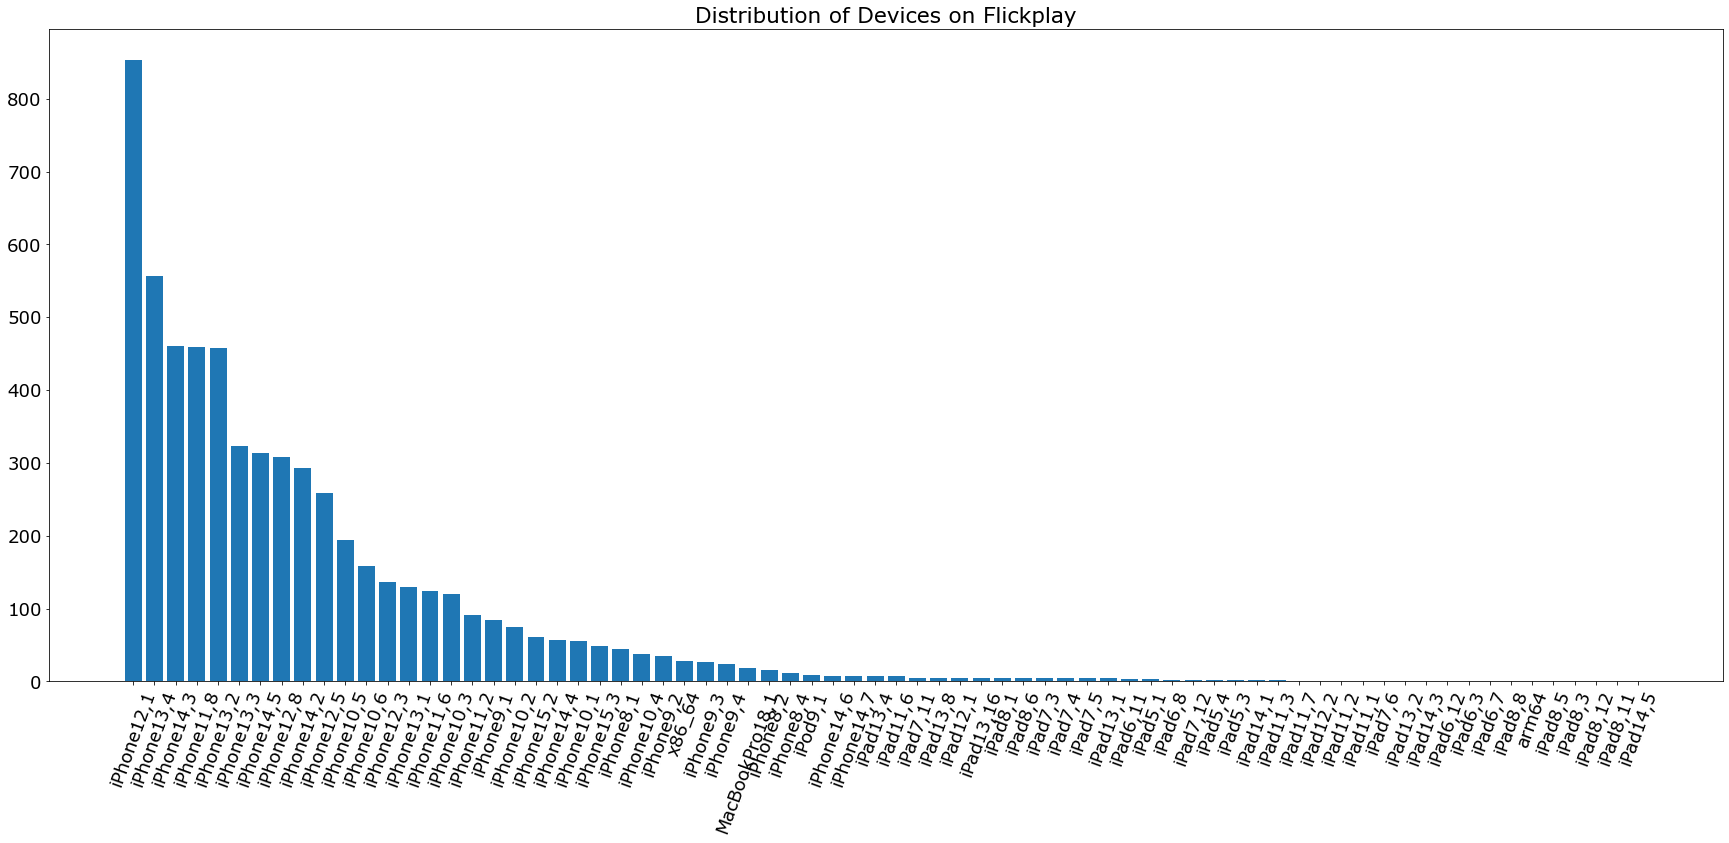

In [68]:
from flickplay.utils import *
from matplotlib import rc
import numpy as np

def set_font_size(size=18):
    font = {'family' : 'verdana',
            'size'   : size}
    rc('font', **font)
    

fig, ax = make_big(f=18,w=30,h=12)
set_font_size()
plt.bar(devices_gr2.model,devices_gr2.user_id )
plt.xticks(rotation=70)
plt.title('Distribution of Devices on Flickplay')


In [42]:
devices_gr2.to_csv('data/device_counts.csv',index=False)
for idx, row in devices_gr2.sort_values(by='user_id', ascending=False).iterrows():
    print(row.model, row.user_id)

FileNotFoundError: [Errno 2] No such file or directory: 'data/device_counts.csv'

In [ ]:
devices_gr3 =  devices[['model','date','user_id']].groupby(['model','date']`)['user_id'].apply(count_distinct).reset_index()
devices_gr3

In [ ]:

@timer_func
def get_device_counts(devices=devices):

    devices_list = [ _ for _ in list(set(devices['model'])) if _ is not None ]
    months = list(set(devices.month_))

    device_counts = []

    for dev in devices_list:
        for month in months:
            for year in ['2022']:

                users = list(set(devices[(devices['model']==dev) & (devices.month_ == month)]['user_id']))
                nusers = len(users)

                device_counts.append({
                            'model': dev,
                            'year': year,
                            'month': month,
                            'users': users,
                            'nusers': nusers})

    return pd.DataFrame.from_records(device_counts)

device_counts = get_device_counts()
device_counts

In [ ]:
devices

In [ ]:
@timer_func
def get_device_aggregates():
    device_aggregates = devices[devices.year_==2022].groupby(['user_id','model','month_', 'year_']).count().reset_index()
    device_aggregates['events'] = device_aggregates['date']
    da = device_aggregates.drop(columns='date')

    da['date'] = [ str(row.year_)+'-'+str(row.month_) for idx, row in da.iterrows() ]
    da = da.drop(columns=['year_','month_',])
    da[['model','date','user_id']].groupby(['model','date']).count()
    return da

da = get_device_aggregates()

In [ ]:
da

In [ ]:
# da['date'] = [ str(row.year_)+'-'+str(row.month_) for idx, row in da.iterrows() ]
# da = da.drop(columns=['year_','month_',])
# da[['model','date','user_id']].groupby(['model','date']).count()

In [ ]:
da.groupby('model').count()['user_id'].to_csv('data/device_aggregates.csv')

In [ ]:
# device_aggregates['events'] = device_aggregates['date']
# da = device_aggregates.drop(columns='date')